In [1]:
## Chris Kellogg

## ############################################################################
## ############################################################################
##
## Python Refresher
##
## ############################################################################
## ############################################################################

##
## This is a refresher of data analysis and visualization using Python.
##
## With the dataset that you choose, perform the following steps:
##
## 1. Write a summary of your data and identify at least two questions to
##    explore visually with your data.
##
## 2. Create a histogram or bar graph from your data.
##
## 3. Create a boxplot from your data.
##
## 4. Create a bivariate plot from your data.
##
## 5. Create any additional visualizations that will help to answer the
##    question(s) you want to answer.
##
## 6. Summarize your results and make a conclusion. Explain how you arrived
##    at this conclusion and how your visualizations support your conclusion.
##

In [2]:
##
## load necessary packages
##

# import and alias Pandas
import pandas as pd

# import and alias NumPy
import numpy as np

# import and alias the plotting package
import matplotlib.pyplot as plt

# import from pybaseball API
import pybaseball
from pybaseball import  playerid_lookup
from pybaseball import  statcast_batter

In [3]:
##
## read and clean up Javy Báez's Season Batting Stats
## -- downloaded from Baseball Reference web page
## -- https://www.baseball-reference.com/players/b/baezja01.shtml
##

# read the Season Batting Stats file
seasons = pd.read_csv('BaezSeasonBatting.csv')

# drop the sub-total rows from the year he was traded
seasons = seasons.query(
    'Year not in (2014, 2021) or Tm == "TOT"'
)

# keep only the fields we want
seasons = pd.DataFrame(seasons[[
    'Year',
    'PA',
    'AB',
    'HR',
    'BB',
    'SO',
    'BA',
    'OBP',
    'SLG',
    'OPS',
    'OPS+'
]])

# preview the season batting stats
seasons

,Year,PA,AB,HR,BB,SO,BA,OBP,SLG,OPS,OPS+
1,2015,80,76,1,4,24,0.289,0.325,0.408,0.733,102
2,2016,450,421,14,15,108,0.273,0.314,0.423,0.737,94
3,2017,508,469,23,30,144,0.273,0.317,0.480,0.796,102
4,2018,645,606,34,29,167,0.290,0.326,0.554,0.881,129
5,2019,561,531,29,28,156,0.281,0.316,0.531,0.847,115
6,2020,235,222,8,7,75,0.203,0.238,0.360,0.599,59
7,2021,547,502,31,28,184,0.265,0.319,0.494,0.813,117
10,2022,590,555,17,26,147,0.238,0.278,0.393,0.671,91
11,2023,547,510,9,24,125,0.222,0.267,0.325,0.593,63
12,2024,289,272,6,12,69,0.184,0.221,0.294,0.516,44


In [4]:
##
## get Javy Báez's MLBAM player ID
##

# look up player id
playerid_lookup('Báez', 'Javier')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,báez,javier,595879,baezj001,baezja01,12979,2014.0,2024.0


In [5]:
##
## get a list all regular-season pitches thrown to Javy Báez in his career
##

# get data from the pybaseball API
javy_baez_career = statcast_batter('2015-01-01', '2024-12-31', 595879)

# keep only the pitches thrown during regular-season games
pitches = javy_baez_career.query('game_type == "R"')

# keep only the fields we want
pitches = pd.DataFrame(pitches[[
    'game_year',
    'pitch_type',
    'release_speed',
    'release_spin_rate',
    'description',
    'zone',
    'type',
    'bb_type',
    'plate_x',
    'plate_z'
]])

# rename the year column
pitches.rename(columns={"game_year": "Year"}, inplace=True)

# mark pitches as fastballs and curveballs where appropriate
pitches['fastball'] = pitches['pitch_type'].apply(
    lambda x: 1 if x in ("FF", "SI", "FC") else 0
)
pitches['breaking_ball'] = pitches['pitch_type'].apply(
    lambda x: 1 if x in ("CU", "KC", "CS", "SL", "ST", "SV") else 0
)

# drop pitches where important info is missing
pitches.dropna(subset=[
    'pitch_type',
    'release_speed',
    'zone',
    'plate_x',
    'plate_z',
    'release_spin_rate'
], inplace=True)

# preview the pitches
pitches

Gathering Player Data


,Year,pitch_type,release_speed,release_spin_rate,description,zone,type,bb_type,plate_x,plate_z,fastball,breaking_ball
38,2020,CH,85.9,1534.0,hit_into_play,12.0,X,line_drive,1.05,2.81,0,0
39,2020,SI,89.5,2153.0,ball,12.0,B,NaN,1.25,3.38,1,0
40,2020,CH,85.5,1629.0,called_strike,9.0,S,NaN,0.62,1.88,0,0
41,2020,FF,95.0,2202.0,ball,14.0,B,NaN,1.63,1.77,1,0
42,2020,FF,94.9,2127.0,foul,7.0,S,NaN,-0.46,2.11,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7591,2021,SI,92.1,1854.0,swinging_strike,4.0,S,NaN,-0.34,2.40,1,0
7592,2021,FF,93.1,2131.0,ball,11.0,B,NaN,-0.20,4.94,1,0
7593,2021,FF,96.9,2231.0,ball,12.0,B,NaN,1.16,3.05,1,0
7594,2021,CU,74.0,2314.0,swinging_strike,14.0,S,NaN,1.31,1.30,0,1


In [6]:
##
## get the aggregate info for all pitches
##

# get the count for each year
pitch_data = pitches \
    .groupby(['Year']) \
    .agg(
        pitch_count = ('pitch_type', 'count')
    ) \
    .reset_index()

# preview the pitches data
pitch_data

,Year,pitch_count
0,2015,279
1,2016,1510
2,2017,1784
3,2018,2160
4,2019,1935
5,2020,905
6,2021,2069
7,2022,2092
8,2023,1961
9,2024,1020


In [7]:
##
## get the aggregate info for fastballs
##

# get the mean velocity and count for each year
fastball_data = pitches \
    .query('fastball == 1') \
    .groupby(['Year']) \
    .agg(
        mean_fb_velo = ('release_speed', 'mean'),
        fb_count = ('pitch_type', 'count')
    ) \
    .reset_index()

# preview the fastball data
fastball_data

,Year,mean_fb_velo,fb_count
0,2015,93.405263,171
1,2016,92.846911,874
2,2017,93.121673,992
3,2018,92.904718,1187
4,2019,93.051683,1099
5,2020,92.624580,476
6,2021,93.222592,1111
7,2022,92.772956,954
8,2023,93.215733,1017
9,2024,93.280591,474


In [8]:
##
## get the aggregate info for breaking balls
##

# get the mean spin rate and count for each year
breaking_ball_data = pitches \
    .query('breaking_ball == 1') \
    .groupby(['Year']) \
    .agg(
        mean_bb_spin = ('release_spin_rate', 'mean'),
        bb_count = ('pitch_type', 'count')
    ) \
    .reset_index()

# preview the breaking ball data
breaking_ball_data

,Year,mean_bb_spin,bb_count
0,2015,2141.298701,77
1,2016,2343.246696,454
2,2017,2378.603741,588
3,2018,2404.890039,773
4,2019,2485.948678,643
5,2020,2545.185915,355
6,2021,2473.761836,697
7,2022,2467.678490,874
8,2023,2455.187679,698
9,2024,2487.671946,442


In [9]:
##
## merge the aggregates to the season data
##

# add pitch data onto the season data
df = pd.merge(
    seasons,
    pitch_data,
    how = 'left',
    on = ['Year']
)

# add fastball data onto the season data
df = pd.merge(
    df,
    fastball_data,
    how = 'left',
    on = ['Year']
)

# add breaking ball data onto the list of 1000-pitch seasons
df = pd.merge(
    df,
    breaking_ball_data,
    how = 'left',
    on = ['Year']
)

# add columns for fastballs and breaking balls as percentage
df['fb_percent'] = df.fb_count / df.pitch_count
df['bb_percent'] = df.bb_count / df.pitch_count

# keep only the fields we want
df = pd.DataFrame(df[[
    'Year',
    'PA',
    'BA',
    'OBP',
    'OPS',
    'OPS+',
    'mean_fb_velo',
    'mean_bb_spin',
    'pitch_count',
    'fb_count',
    'fb_percent',
    'bb_count',
    'bb_percent'
]])

df

,Year,PA,BA,OBP,OPS,OPS+,mean_fb_velo,mean_bb_spin,pitch_count,fb_count,fb_percent,bb_count,bb_percent
0,2015,80,0.289,0.325,0.733,102,93.405263,2141.298701,279,171,0.612903,77,0.275986
1,2016,450,0.273,0.314,0.737,94,92.846911,2343.246696,1510,874,0.578808,454,0.300662
2,2017,508,0.273,0.317,0.796,102,93.121673,2378.603741,1784,992,0.556054,588,0.329596
3,2018,645,0.290,0.326,0.881,129,92.904718,2404.890039,2160,1187,0.549537,773,0.357870
4,2019,561,0.281,0.316,0.847,115,93.051683,2485.948678,1935,1099,0.567959,643,0.332300
5,2020,235,0.203,0.238,0.599,59,92.624580,2545.185915,905,476,0.525967,355,0.392265
6,2021,547,0.265,0.319,0.813,117,93.222592,2473.761836,2069,1111,0.536974,697,0.336878
7,2022,590,0.238,0.278,0.671,91,92.772956,2467.678490,2092,954,0.456023,874,0.417782
8,2023,547,0.222,0.267,0.593,63,93.215733,2455.187679,1961,1017,0.518613,698,0.355941
9,2024,289,0.184,0.221,0.516,44,93.280591,2487.671946,1020,474,0.464706,442,0.433333


In [10]:
##
## subset the data for just the specific question we want to address
##

# keep only the fields we want
df = pd.DataFrame(df[[
    'Year',
    'OPS+',
    'bb_percent'
]])

df

,Year,OPS+,bb_percent
0,2015,102,0.275986
1,2016,94,0.300662
2,2017,102,0.329596
3,2018,129,0.357870
4,2019,115,0.332300
5,2020,59,0.392265
6,2021,117,0.336878
7,2022,91,0.417782
8,2023,63,0.355941
9,2024,44,0.433333


In [11]:
##
## 1. Write a summary of your data and identify at least two questions to
##    explore visually with your data.
##

# I've been a Cubs fan for about 40 years or so, and they've only won the
# World Series once in that time.  One of the most exciting players on that
# winning team was Javier Báez.  He was a good hitter, and many Cubs fans were
# disappointed when Báez was traded by the Cubs instead of being signed to a
# contract extension in 2021.  In the three seasons since the trade, Báez has
# been a much worse hitter than he was during his time in Chicago, often
# looking overmatched and swinging at pitches that are unhittable.  I built a
# data set (from Baseball Reference and Statcast data) to see whether the
# decline in performance can be explained by the selection and quality of
# pitches thrown to Báez.

## ############################################################################
# Q. In three years since 2021, are MLB pitchers throwing Javier Báez more
#    breaking pitches, explaining his decline in performance?
## ############################################################################

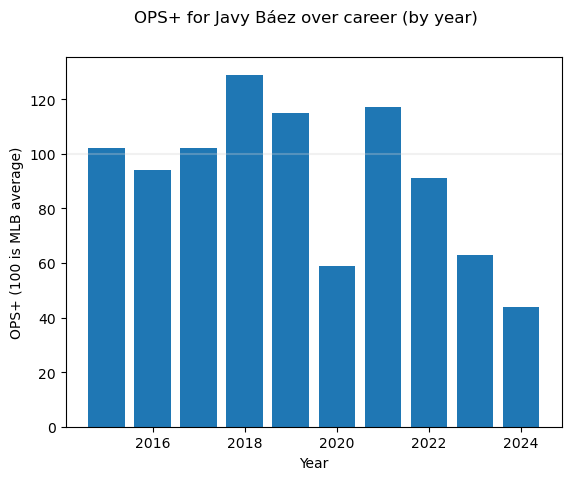

In [12]:
##
## 2. Create a histogram or bar graph from your data.
##

# plot the OPS+ for each year
plt.bar(df['Year'], df['OPS+'])

# add a chart title
plt.suptitle('OPS+ for Javy Báez over career (by year)')

# add the axis labels
plt.xlabel('Year')
plt.ylabel('OPS+ (100 is MLB average)')

# add the MLB average
plt.axhline(y = 100, color = 'lightgray', alpha=0.3) 

# show the plot
plt.show()

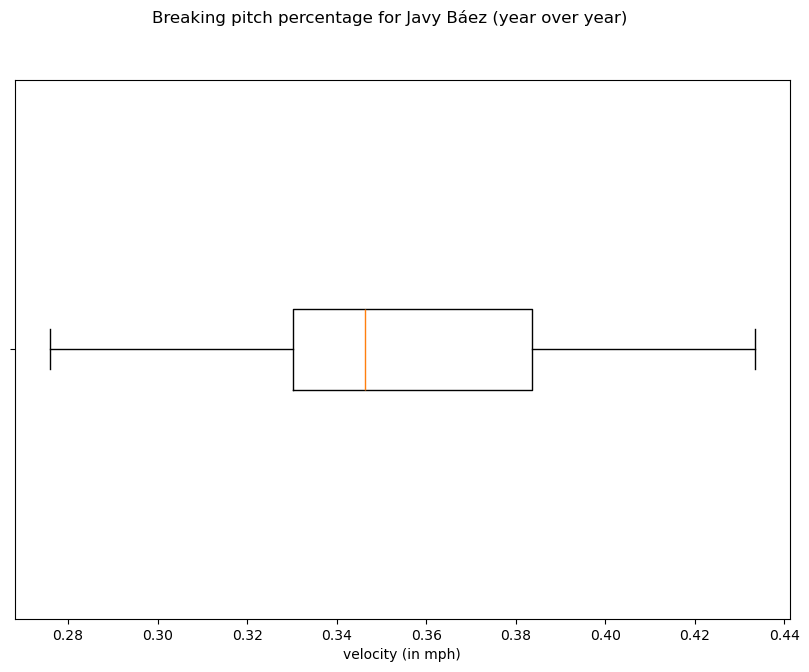

In [13]:
##
## 3. Create a boxplot from your data.
##

# box plot the mean fastball velocity
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot(df.bb_percent, vert = 0)

# add a chart title
plt.suptitle('Breaking pitch percentage for Javy Báez (year over year)')

# remove y-axis labels
ax.set_yticklabels([''])
plt.ylabel('')

# add the x-axis label
plt.xlabel('velocity (in mph)')

# show plot
plt.show()

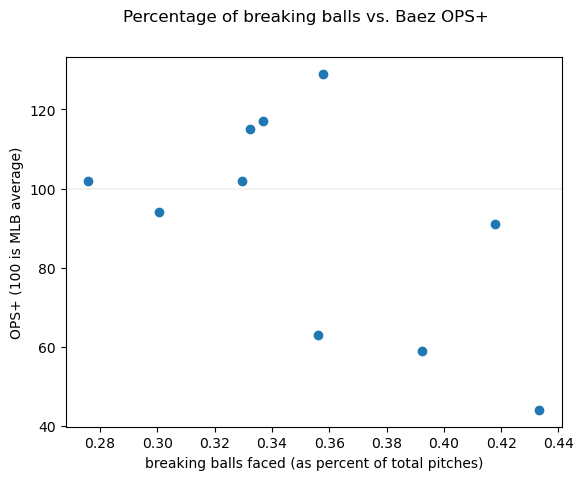

In [14]:
##
## 4. Create a bivariate plot from your data.
##

# plot the percentage of breaking balls against OPS+
plt.scatter(df['bb_percent'], df['OPS+'])

# add a chart title
plt.suptitle('Percentage of breaking balls vs. Baez OPS+')

# add the x-axis label
plt.xlabel('breaking balls faced (as percent of total pitches)')
plt.ylabel('OPS+ (100 is MLB average)')

# add the MLB average
plt.axhline(y = 100, color = 'lightgray', alpha=0.3) 

# show plot
plt.show()

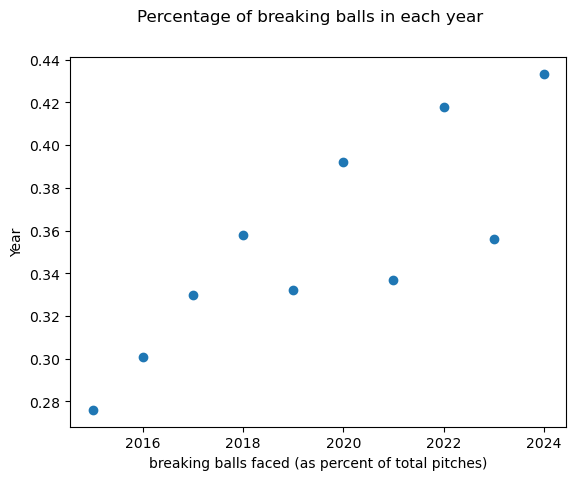

In [15]:
##
## 5. Create any additional visualizations that will help to answer the
##    question(s) you want to answer.
##

# plot the percentage of breaking balls in each year
plt.scatter(df['Year'], df['bb_percent'])

# add a chart title
plt.suptitle('Percentage of breaking balls in each year')

# add the x-axis label
plt.xlabel('breaking balls faced (as percent of total pitches)')
plt.ylabel('Year')

# show plot
plt.show()

In [16]:
##
## 6. Summarize your results and make a conclusion. Explain how you arrived
##    at this conclusion and how your visualizations support your conclusion.
##

# Based on the bar chart above, we can see that Báez's OPS+ (sort of an
# overall measure of offensive value, normalized against the mean performance
# of all MLB hitters) has been declining sharply since the 2021 season, when
# he was traded from the Cubs.  From the box-and-whisker plot, we can see that
# the percentage of breaking balls thrown by MLB pitcher to Báez has varied
# widely over his career, and from the first scatter plot, it's pretty evident
# that Báez generally performs worse offensively when the pitch mix includes
# more breaking balls.  The second scatter plot suggests that MLB pitchers
# have discovered this, throwing more breaking balls to Báez as his career
# has progressed.

# In three years since 2021, MLB pitchers have thrown Javier Báez a higher
# percentage of breaking pitches than in any other three-year stretch,
# including the two highest percentages during his career.  On top of that,
# he's seen the highest percentage of breaking balls this season.

## ############################################################################
# A. It's safe to say that in three years since 2021, MLB pitchers are
#    throwing Javier Báez more breaking pitches, at least partially explaining
#    his decline in performance.
## ############################################################################